<a href="https://colab.research.google.com/github/mydreamis-18/Papering_Defects_AI_Project/blob/master/Efficent_Net___keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !unzip "/content/drive/MyDrive/open.zip"

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
gen=ImageDataGenerator( rescale=1./255)

In [4]:
train_folder_path = '/content/train';
train_generator = gen.flow_from_directory(directory= train_folder_path,target_size=(100,100),batch_size=64,shuffle=True , class_mode='categorical' )

Found 3457 images belonging to 19 classes.


In [5]:
img=train_generator.next()
img,label=train_generator.next()

In [6]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D ,MaxPooling2D ,BatchNormalization,Flatten,Dropout , GlobalMaxPooling2D


In [7]:
#다양한 종류의 레이어와 함수, 메트릭스, 학습률 스케줄러, 손실 함수, 이미지 및 텍스트 처리
#pip install tensorflow_addons

In [8]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import math

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:
RESIZED_WIDTH = 256
RESIZED_HEIGHT = 256
train_img_generator = ImageDataGenerator(rescale=1/255.)
train_img_flow = train_img_generator.flow_from_directory(
train_folder_path , target_size=(RESIZED_WIDTH, RESIZED_HEIGHT))


Found 3457 images belonging to 19 classes.


In [10]:
#B0~B7,L2까지 차이를 만드는 하이퍼파라미터는 4개로 width_coefficient ,depth_coefficient ,default_resolution,dropout_rate  를 건드시면 됩니다.
se_ratio = 4
expand_ratio = 6
width_coefficient = 1.6 #채널 수 . 커질수록 정확하지만 더 많은 계산 요구 
depth_coefficient = 2.2 # 깊이 
default_resolution = 456 # 해상도 
input_channels = 3
depth_divisor= 8 
dropout_rate = 0.4 #
drop_connect_rate = 0.2


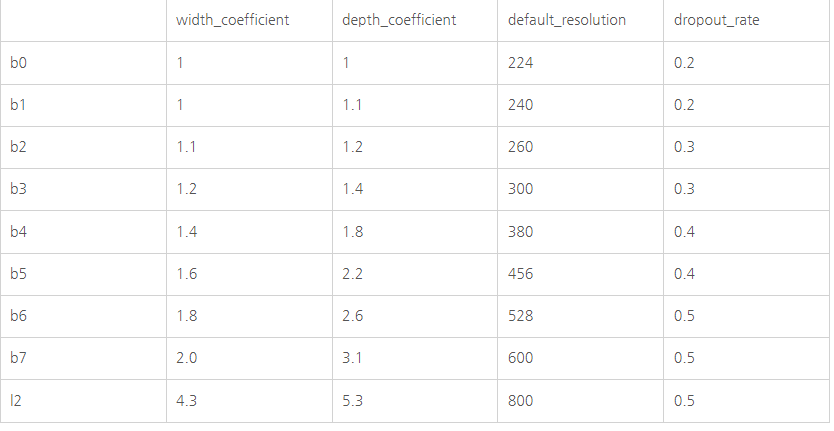

In [11]:
#layer 에 대한 매개변수 . 
kernel_size = [3,3,5,3,5,5,3]
num_repeat = [1,2,2,3,3,4,1] #반복횟수 
output_filters = [16,24,40,80,112,192,320]
strides = [1,2,2,2,1,2,1]
MBConvBlock_1_True  =  [True,False,False,False,False,False,False]


In [12]:
def round_repeats(repeats, depth_coefficient):
    return int(math.ceil(depth_coefficient * repeats))
    

In [13]:
def round_filters(filters, width_coefficient, depth_divisor):
    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)
#깊이 와 필터수를 하이퍼파라미터에 따라 바꿔주는 함수




In [14]:
class DropConnect(layers.Layer):
    def __init__(self, drop_connect_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_connect_rate = drop_connect_rate

    def call(self, inputs, training):
        def _drop_connect():
            keep_prob = 1.0 - self.drop_connect_rate

            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob
            random_tensor += K.random_uniform([batch_size, 1, 1, 1], dtype=inputs.dtype)
            binary_tensor = tf.floor(random_tensor)
            output = tf.math.divide(inputs, keep_prob) * binary_tensor
            return output

        return K.in_train_phase(_drop_connect, inputs, training=training)


In [15]:
def SEBlock(filters,reduced_filters):
    def _block(inputs):
        x = layers.GlobalAveragePooling2D()(inputs)
        x = layers.Reshape((1,1,x.shape[1]))(x)
        x = layers.Conv2D(reduced_filters, 1, 1)(x)
        x = tfa.activations.mish(x)
        x = layers.Conv2D(filters, 1, 1)(x)
        x = layers.Activation('sigmoid')(x)
        x = layers.Multiply()([x, inputs])
        return x
    return _block
#그냥 입력에 쓸모없는 부분을 sigmoid를  통해 정규화된 값(0~1)을 곱하여제거하는 블록입니다.


In [16]:
def MBConvBlock(x,kernel_size, strides,drop_connect_rate,output_channels,MBConvBlock_1_True=False):
    output_channels = round_filters(output_channels,width_coefficient,depth_divisor)
    if MBConvBlock_1_True:
        block = layers.DepthwiseConv2D(kernel_size, strides,padding='same', use_bias=False)(x)
        block = layers.BatchNormalization()(block)
        block = tfa.activations.mish(block)
        block = SEBlock(x.shape[3],x.shape[3]/se_ratio)(block)
        block = layers.Conv2D(output_channels, (1,1), padding='same', use_bias=False)(block)
        block = layers.BatchNormalization()(block)
        return block

    channels = x.shape[3]
    expand_channels = channels * expand_ratio
    block = layers.Conv2D(expand_channels, (1,1), padding='same', use_bias=False)(x)
    block = layers.BatchNormalization()(block)
    block = tfa.activations.mish(block)
    block = layers.DepthwiseConv2D(kernel_size, strides,padding='same', use_bias=False)(block)
    block = layers.BatchNormalization()(block)
    block = tfa.activations.mish(block)
    block = SEBlock(expand_channels,channels/se_ratio)(block)
    block = layers.Conv2D(output_channels, (1,1), padding='same', use_bias=False)(block)
    block = layers.BatchNormalization()(block)
    if x.shape[3] == output_channels:
        block = DropConnect(drop_connect_rate)(block)
        block = layers.Add()([block, x])
    return block


In [17]:
def EffNet(num_classes):
    x_input = layers.Input(shape=(default_resolution,default_resolution,input_channels))    
    x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), (3,3), 2,padding='same', use_bias=False)(x_input)
    x = layers.BatchNormalization()(x)
    x = tfa.activations.mish(x)
    num_blocks_total = sum(num_repeat)
    block_num = 0
    for i in range(len(kernel_size)):
        round_num_repeat = round_repeats(num_repeat[i], depth_coefficient)
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        x = MBConvBlock(x,kernel_size[i],strides[i],drop_rate,output_filters[i],MBConvBlock_1_True = MBConvBlock_1_True[i])
        block_num += 1
        if round_num_repeat > 1:
            for bidx in range(round_num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                x = MBConvBlock(x,kernel_size[i],1,drop_rate,output_filters[i],MBConvBlock_1_True = MBConvBlock_1_True[i])
                block_num += 1
    x = layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,padding='same',use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tfa.activations.mish(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes,activation='softmax')(x)
    model = tf.keras.models.Model(inputs=x_input, outputs=x)
    return model


In [18]:
net = EffNet(19)

In [19]:
net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 456, 456, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 228, 228, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 228, 228, 48  192        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
#net = keras.applications.EfficientNetB0()


In [21]:
#net.summary()

In [22]:
 net.compile(optimizer=Adam(learning_rate=0.0001),
               loss='categorical_crossentropy', metrics=['acc'])

In [23]:
train_history = net.fit(train_generator, epochs=10)

Epoch 1/10
55/55 [==============================] - 178s 1s/step - loss: 2.5842 - acc: 0.2736
Epoch 2/10
55/55 [==============================] - 55s 988ms/step - loss: 2.2898 - acc: 0.3870
Epoch 3/10
55/55 [==============================] - 54s 981ms/step - loss: 2.2069 - acc: 0.3807
Epoch 4/10
55/55 [==============================] - 54s 965ms/step - loss: 2.2028 - acc: 0.3792
Epoch 5/10
55/55 [==============================] - 55s 986ms/step - loss: 2.1415 - acc: 0.3902
Epoch 6/10
55/55 [==============================] - 55s 990ms/step - loss: 2.1167 - acc: 0.3931
Epoch 7/10
55/55 [==============================] - 55s 992ms/step - loss: 2.0802 - acc: 0.3899
Epoch 8/10
55/55 [==============================] - 54s 985ms/step - loss: 2.0310 - acc: 0.4006
Epoch 9/10
55/55 [==============================] - 53s 964ms/step - loss: 1.9608 - acc: 0.3963
Epoch 10/10
55/55 [==============================] - 54s 974ms/step - loss: 1.9103 - acc: 0.4134
